---
title: "filling missing values"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)  # white graphs, with large and legible letters
import random

# %matplotlib widget

In [2]:
def plot_all_columns(data):
    column_list = data.columns
    
    fig, ax = plt.subplots(len(column_list),1, sharex=True, figsize=(10,len(column_list)*2))

    if len(column_list) == 1:
        ax.plot(data[column_list[0]])
        return
    for i, column in enumerate(column_list):
        ax[i].plot(data[column])
        ax[i].set(ylabel=column)
    
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax[i].xaxis.set_major_locator(locator)
    ax[i].xaxis.set_major_formatter(formatter)

    return

In [3]:
def plot_missing_vals(original, new, title=''):
    column_list = original.columns
    
    fig, ax = plt.subplots(len(column_list),1, sharex=True, figsize=(10,len(column_list)*2))

    if len(column_list) == 1:
        ax.set_title(title)
        ax.plot(new[column_list[0]], c='r')
        ax.plot(original[column_list[0]])
        return
    for i, column in enumerate(column_list):
        ax[i].plot(original[column_list[0]], c='tab:blue', alpha=0.2)
        ax[i].plot(new[column], c='r')
        ax[i].plot(original[column])
        if i != 0:
            ax[i].scatter(new[column].index,new[column].values, marker='o', s=4, c='r')
            ax[i].scatter(original[column].index,original[column].values, marker='o', s=4)
        else:
            ax[i].set_title(title)
        ax[i].set(ylabel=column)
        # calculate and display MSE
        mse = mean_squared_error(original[column_list[0]], new[column])
        ax[i].text(0.01, 0.95, f'MSE: {mse:.4f}', transform=ax[i].transAxes, fontsize=12, verticalalignment='top')
    
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax[i].xaxis.set_major_locator(locator)
    ax[i].xaxis.set_major_formatter(formatter)

    return

In [4]:
df = pd.read_csv('data_missing.csv', index_col='date', parse_dates=True)
df

,original,mis_1,mis_2,mis_3
date,,,,
2019-07-01 00:00:00,21.808333,21.808333,21.808333,21.808333
2019-07-01 02:00:00,20.808333,20.808333,20.808333,20.808333
2019-07-01 04:00:00,20.283333,20.283333,20.283333,20.283333
2019-07-01 06:00:00,22.216667,22.216667,22.216667,22.216667
2019-07-01 08:00:00,26.091667,26.091667,NaN,26.091667
...,...,...,...,...
2019-08-31 14:00:00,29.400000,29.400000,NaN,29.400000
2019-08-31 16:00:00,26.808333,26.808333,26.808333,26.808333
2019-08-31 18:00:00,24.050000,24.050000,24.050000,24.050000


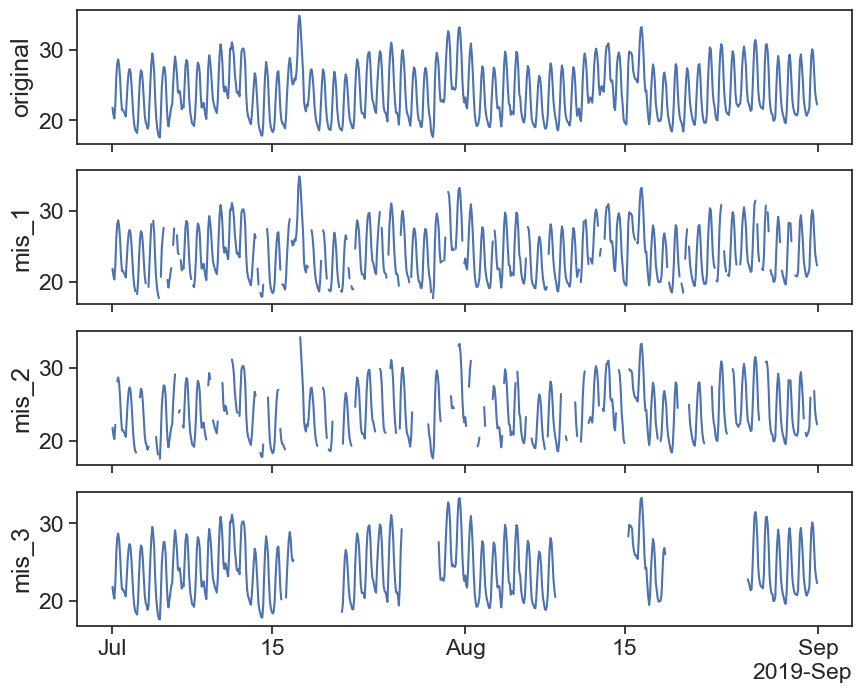

In [5]:
plot_all_columns(df)

## Forward fill

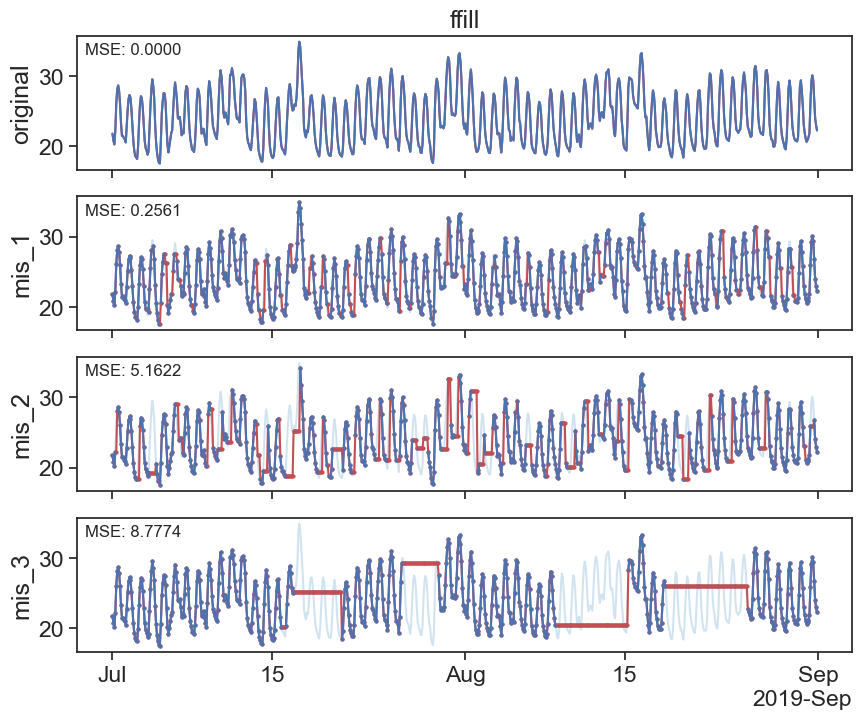

In [6]:
df_ffil = df.fillna(method='ffill')
plot_missing_vals(df, df_ffil, title='ffill')

## Backwrds fill

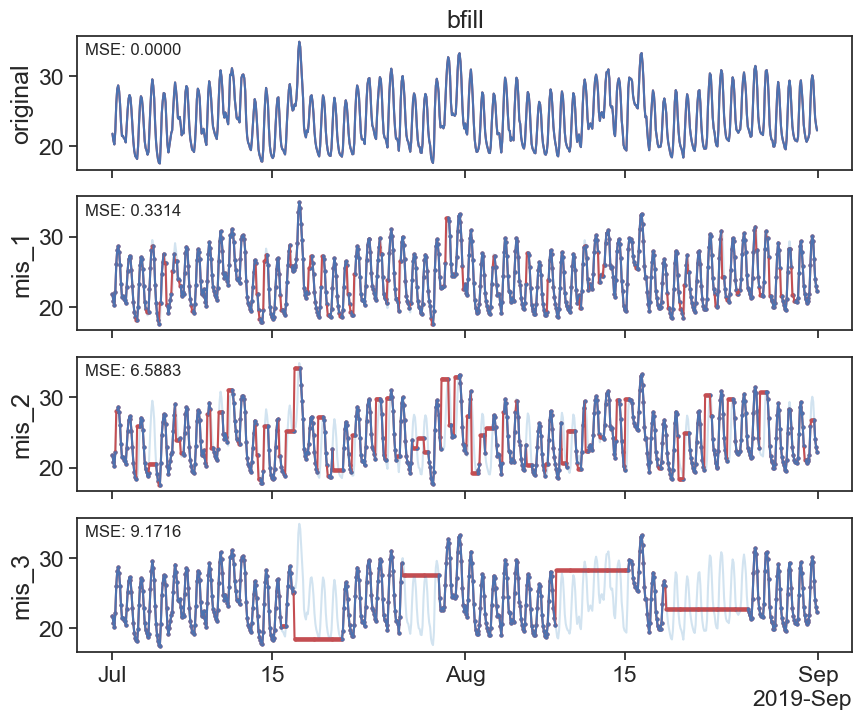

In [7]:
df_bfil = df.fillna(method='bfill')
plot_missing_vals(df, df_bfil, title='bfill')

## Interpolation
### linear

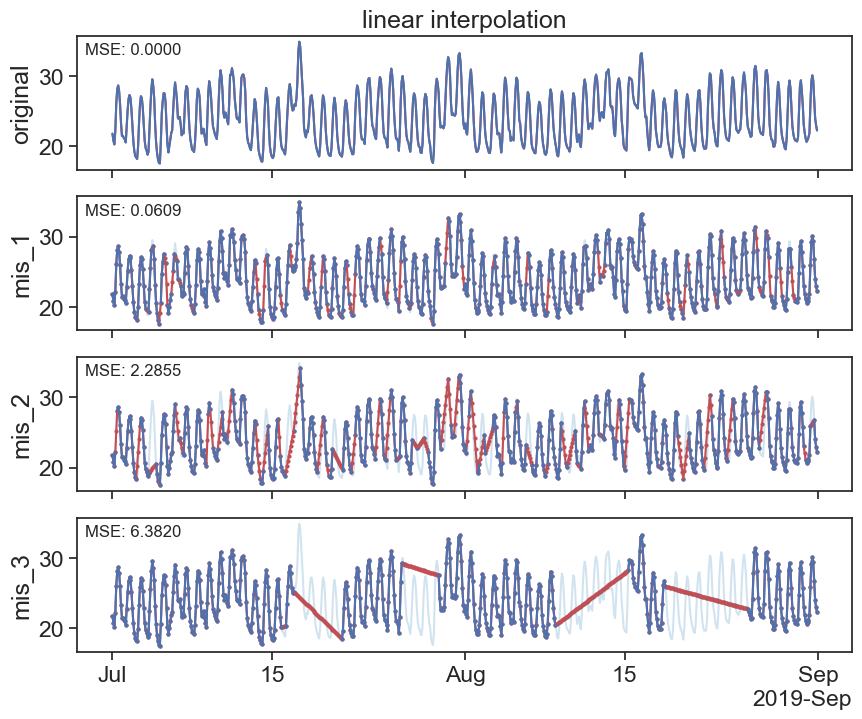

In [8]:
interpolated_df = df.interpolate(method='linear')
plot_missing_vals(df, interpolated_df, title='linear interpolation')

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html

### cubic splines

Source: <https://docs.scipy.org/doc/scipy/tutorial/interpolate/1D.html#cubic-splines>

Piecewise linear interpolation produces corners at data points, where linear pieces join. To produce a smoother curve, you can use cubic splines, where the interpolating curve is made of cubic pieces with **matching first and second derivatives**.

![](cubic_c2_spline.png)

::: {.column-margin}
Source: <https://kluge.in-chemnitz.de/opensource/spline/>
:::

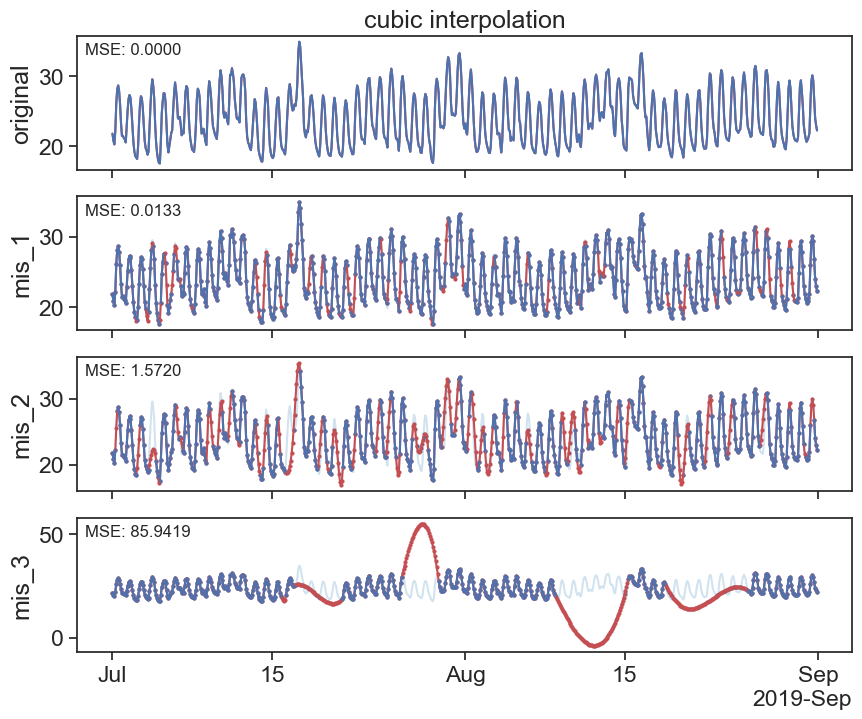

In [9]:
interpolated_cubic_df = df.interpolate(method='cubic')
plot_missing_vals(df, interpolated_cubic_df, title='cubic interpolation')

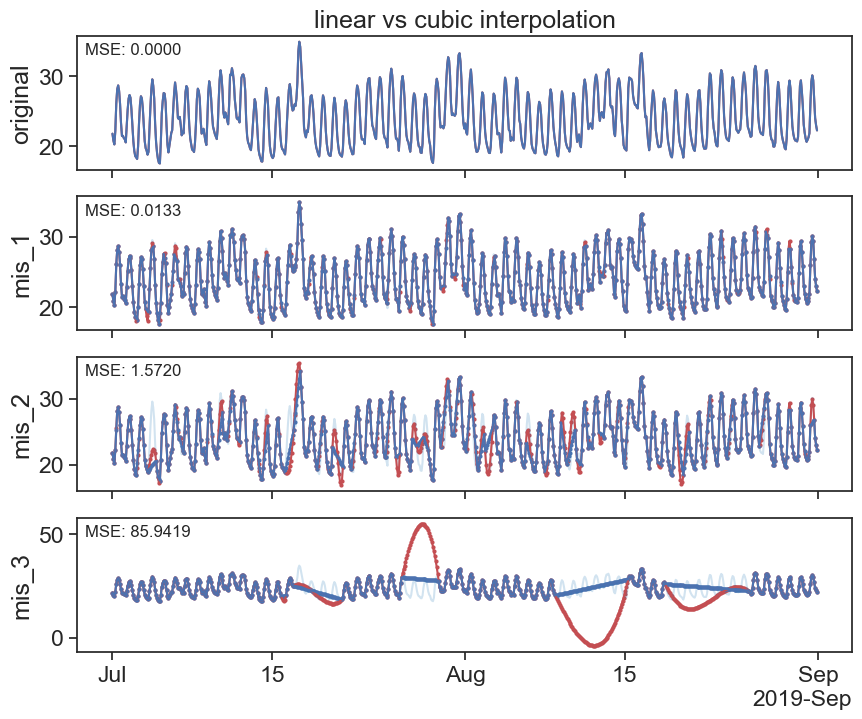

In [10]:
plot_missing_vals(interpolated_df, interpolated_cubic_df, title='linear vs cubic interpolation')

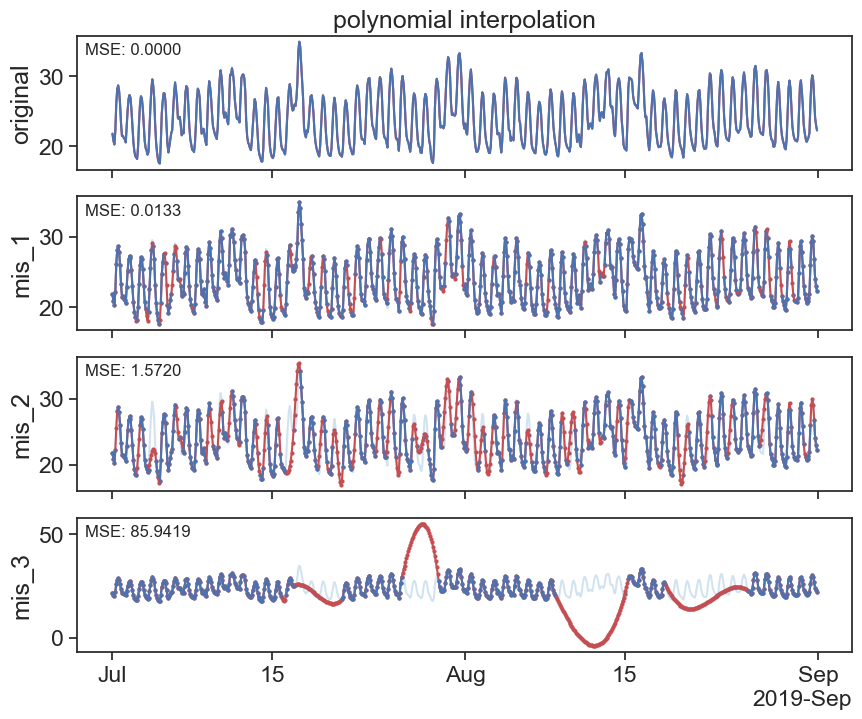

In [11]:
interpolated_poly_df = df.interpolate(method='polynomial', order=3)
plot_missing_vals(df, interpolated_poly_df, title='polynomial interpolation')

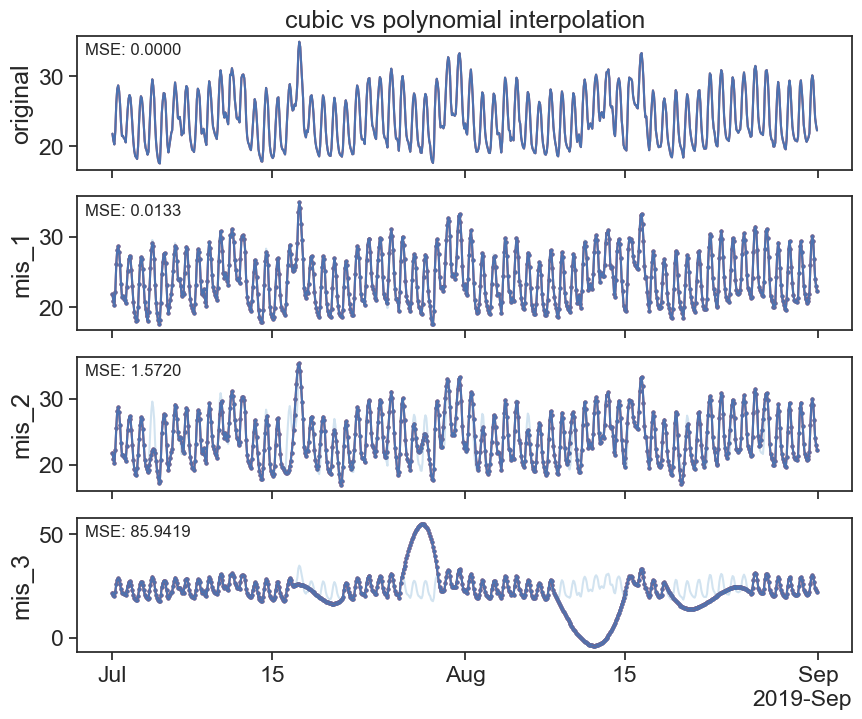

In [12]:
plot_missing_vals(interpolated_cubic_df, interpolated_poly_df, title='cubic vs polynomial interpolation')

All available interpolation types can be found at the [pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html)

## random forest

Here we explore the use of a commnly used Machine learning model - RandomForest

In [13]:

def fillna_randomforest(series):
    # Ensure the series index is a datetime object
    if not isinstance(series.index, pd.DatetimeIndex):
        raise ValueError("Index must be a DatetimeIndex")
    
    # Split series into observed and missing values
    observed = series.dropna()
    missing = series[series.isna()]
    
    # Extracting time-based features
    def create_features(index):
        return np.array([index.hour, index.day, index.month, index.year]).T
    
    # Create features for training data
    X_train = create_features(observed.index)
    y_train = observed.values
    
    # Train the Random Forest regression model
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    
    # Create features for missing data and predict
    X_missing = create_features(missing.index)
    predicted_values = model.predict(X_missing)
    
    # Assign the predicted values to the missing positions
    series_filled = series.copy()
    series_filled[series_filled.isna()] = predicted_values

    return series_filled

In [14]:
columns = df.columns
df_rf = df.copy()
for i, column in enumerate(columns):
    if i == 0:
        continue
    df_rf[column] = fillna_randomforest(df_rf[column])

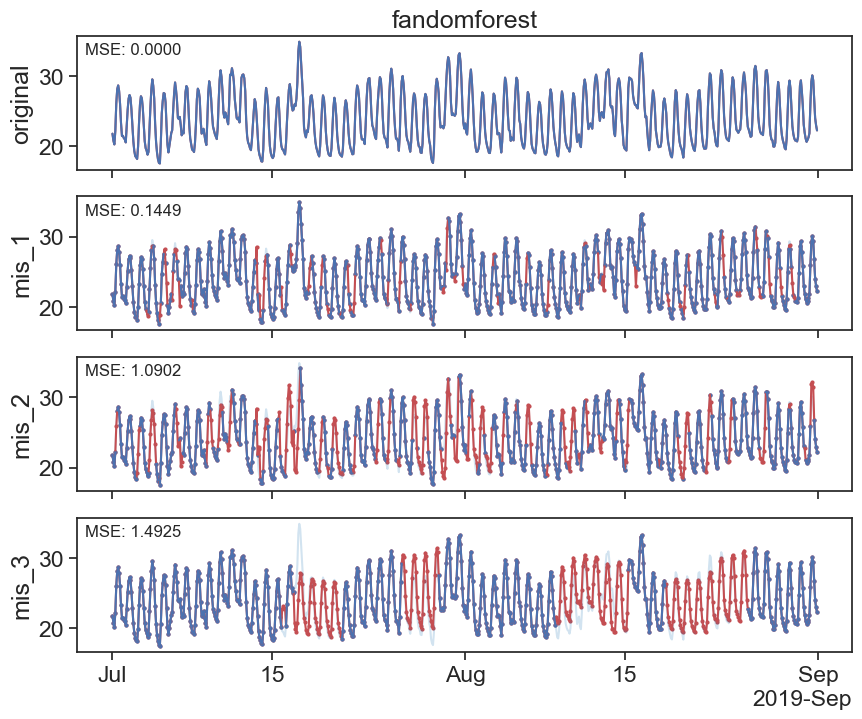

In [15]:
plot_missing_vals(df, df_rf, title='fandomforest')

# SARIMAX

In [16]:
# Model Building and Imputation
# Build a SARIMA model on the data with gaps
seasonal_period = 24/2
model = SARIMAX(df['mis_3'], order=(2, 1, 0), seasonal_order=(1, 1, 1, seasonal_period), enforce_stationarity=True)
results = model.fit(disp=False)

# Impute missing values one by one
ts_data_filled = df['mis_3'].copy()
missing_indices = df['mis_3'].loc[df['mis_3'].isna()]
for missing_index in missing_indices.index:
    ts_data_filled[missing_index] = results.predict(start=missing_index, end=missing_index)


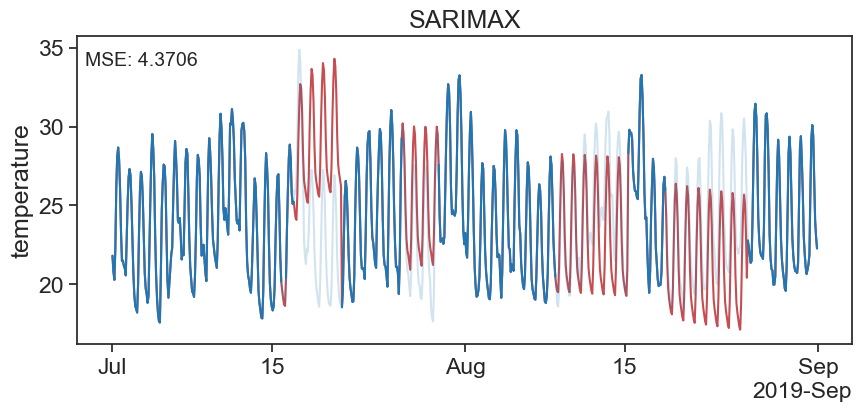

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ts_data_filled, label='Imputed Data', color='r')
ax.plot(df['original'], label='Original Data', color='tab:blue', alpha=0.2)
ax.plot(df['mis_3'], label='Data with Gaps', color='tab:blue', alpha=1)
ax.set_ylabel('temperature')
ax.set_title('SARIMAX')
# calculate and display MSE
mse = mean_squared_error(df['original'], ts_data_filled)
ax.text(0.01, 0.95, f'MSE: {mse:.4f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
# ax.legend()

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)


The above looks good at the begining of the gap but at the end of the gap it looks bad. That is because we are forcasting and not filling in between the lines...

# SARIMAX cross fade

In [18]:
def find_nan_gaps_indexes_datetime(series):
    """
    Find and pair the start and end datetime indexes of gaps in a pandas Series with a datetime index containing NaN values.

    Parameters:
    series (pandas Series): The input pandas Series with a datetime index containing NaN gaps.

    Returns:
    list of tuples: A list of tuples where each tuple contains the start datetime index and end datetime index of a gap.
    """
    is_nan = series.isna().values
    start_indexes = np.where(is_nan & ~np.roll(is_nan, 1))[0]
    end_indexes = np.where(is_nan & ~np.roll(is_nan, -1))[0]

    # If the last gap extends to the end of the Series, add its end index
    if is_nan[-1]:
        end_indexes = np.append(end_indexes, len(series) - 1)

    # Pair start and end datetime indexes together
    gap_pairs = [(series.index[start], series.index[end]) for start, end in zip(start_indexes, end_indexes)]
    
    return gap_pairs

In [19]:
def forward_reverse_SARIMAX(ts_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), seasonal_period=12, enforce_stationarity=True):
    # The function forward_reverse_SARIMAX aims to impute missing values in a time series dataset using a
    # SARIMAX model approach, both in the original and reversed order of the data. Initially, it builds a 
    # SARIMAX model on the provided dataset to predict and fill in the missing values. Then, it reverses 
    # the time series data, applies another SARIMAX model on this reversed data, and imputes the missing 
    # values again. After obtaining the imputed datasets from both forward and reverse directions, the 
    # function iteratively blends the imputed values from both models for each missing point, adjusting 
    # the weight given to the forward and reverse imputations based on the position within the missing data gap. 
    # This blended approach aims to leverage the predictive insights from both the preceding and succeeding 
    # data points, potentially providing a more accurate and balanced imputation for the missing values.
    
    # Model Building and Imputation
    # Build a SARIMA model on the data with gaps
    model = SARIMAX(ts_data, order=order, seasonal_order=seasonal_order, enforce_stationarity=enforce_stationarity)
    results = model.fit(disp=False)

    # Impute missing values one by one
    ts_data_filled = ts_data.copy()
    missing_indices = ts_data.loc[ts_data.isna()]
    for missing_index in missing_indices.index:
        ts_data_filled[missing_index] = results.predict(start=missing_index, end=missing_index)
    

    # Reverse the time series
    ts_data_reversed = ts_data.iloc[::-1]

    # Build SARIMAX model on reversed data
    model_reversed = SARIMAX(ts_data_reversed, order=order, seasonal_order=seasonal_order, enforce_stationarity=enforce_stationarity)
    results_reversed = model_reversed.fit(disp=False)

    # Impute missing values in reversed data
    ts_data_filled_reversed = ts_data_reversed.copy()
    missing_indices_reversed = ts_data_reversed.loc[ts_data_reversed.isna()]
    for missing_index in missing_indices_reversed.index:
        ts_data_filled_reversed[missing_index] = results_reversed.predict(start=missing_index, end=missing_index)

    # Reverse the imputed data back to original order
    ts_data_filled_reversed = ts_data_filled_reversed.iloc[::-1]


    # Initialize a series to hold the combined predictions
    ts_data_combined = ts_data.copy()

    # Iterate over each gap
    for gap_start, gap_end in find_nan_gaps_indexes_datetime(ts_data):
        # print(gap_start)
        # Calculate the number of periods in the gap
        gap = ts_data[gap_start:gap_end]
        gap_length = len(gap)
        
        # Iterate over each index in the gap
        # for i, index in enumerate(pd.date_range(start=gap_start, end=gap_end, freq=ts_data.index.freq)):
        for i, index in enumerate(gap.index):
            forward_weight = (gap_length - i) / gap_length
            backward_weight = i / gap_length
            combined_prediction = (ts_data_filled.at[index] * forward_weight +
                                ts_data_filled_reversed.at[index] * backward_weight)
            ts_data_combined.at[index] = combined_prediction
    
    return ts_data_combined
    

In [20]:
f_r_SARIMAX = forward_reverse_SARIMAX(df['mis_3'])

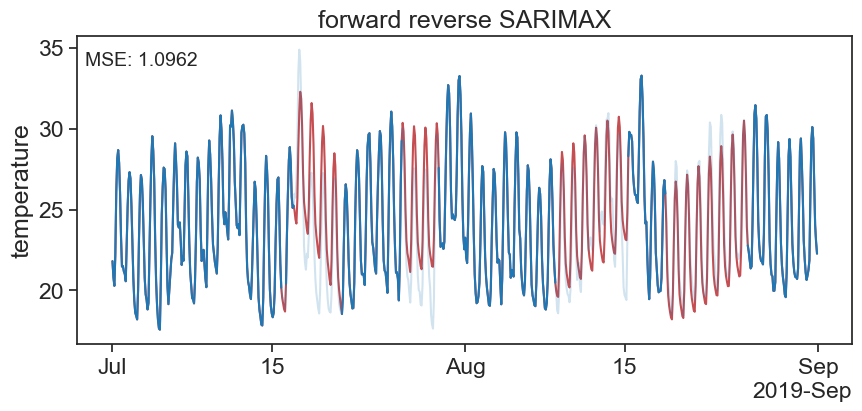

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(f_r_SARIMAX, label='Imputed Data', color='r')
ax.plot(df['original'], label='Original Data', color='tab:blue', alpha=0.2)
ax.plot(df['mis_3'], label='Data with Gaps', color='tab:blue', alpha=1)
ax.set_ylabel('temperature')
ax.set_title('forward reverse SARIMAX')
# calculate and display MSE
mse = mean_squared_error(df['original'], f_r_SARIMAX)
ax.text(0.01, 0.95, f'MSE: {mse:.4f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
# ax.legend()

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

In [22]:
# Calculate MSE
mse_fr = mean_squared_error(df['original'], f_r_SARIMAX)
mse_rf = mean_squared_error(df['original'], df_rf['mis_3'])

print("Mean Squared Error sarimax:", mse_fr)
print("Mean Squared Error rand:", mse_rf)

Mean Squared Error sarimax: 1.0961749546737887
Mean Squared Error rand: 1.4924638305799802
